# Text as data, analyzing kindle review

written by Mark Marner-Hausen 

 

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

It is possible that the modules below need to be loaded manually.

In [3]:
#!pip install nltk
#!python3 -m nltk.downloader stopwords 
#!python3 -m nltk.downloader wordnet
#!python3 -m nltk.downloader omw-1.4

In [4]:
data = pd.read_csv('data/kindle_reviews.csv', header=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      982619 non-null  int64 
 1   asin            982619 non-null  object
 2   helpful         982619 non-null  object
 3   overall         982619 non-null  int64 
 4   reviewText      982597 non-null  object
 5   reviewTime      982619 non-null  object
 6   reviewerID      982619 non-null  object
 7   reviewerName    978803 non-null  object
 8   summary         982618 non-null  object
 9   unixReviewTime  982619 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 75.0+ MB


The data set contains over 1,000,000 reviews, for convenience, only a random subsample of size p = 15% of the data is considered hereafter. For better predictions, the entire data set should be considered by setting p = 1.

In [6]:
np.random.seed(42)
p = 0.15
data = data[np.random.rand(data.shape[0]) < p]



---



**Part 1: Data Cleaning**

Drop unnecessary columns and rename label.  

In [7]:
tmp = data.copy()
data = tmp.drop(columns = ['summary', 'reviewerName', 'helpful', 'Unnamed: 0',
                     'reviewTime', 'unixReviewTime', 'reviewerID', 'asin'])
data = data.rename(columns = {'overall' : 'stars'})

Reduce the rating on a scale from 1 to 5 stars to a binary variable. Ratings of 4 to 5 stars are labeled 1 (positive), while ratings of 1 to 3 stars are labeled 0 (negative).

The percentage of positive reviews is:  0.8448724409877821


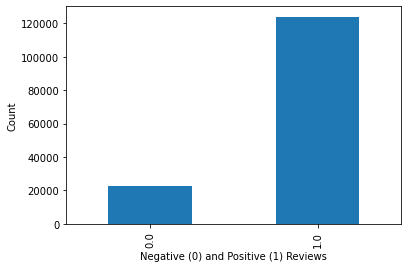

In [8]:
data['y_rating'] = np.zeros(data.shape[0])

tmp = data.copy()
data.loc[tmp.stars > 3, 'y_rating'] = 1

data.drop(columns = ['stars'], inplace = True)

print('The percentage of positive reviews is: ', 
      (np.sum(data.y_rating)/(data.shape[0])))


data.y_rating.value_counts().plot(kind="bar")
plt.ylabel('Count')
plt.xlabel('Negative (0) and Positive (1) Reviews')
plt.show()

Note that the data set is unbalanced in terms of labeles, this will play an important role later in this analysis. 

Next, preprocessing of the text data. This includes removing all punctuation marks, stop words, single digits, etc., as well as stemming and lemmatization. 

In [9]:
import gensim
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn import preprocessing


gensim_sws = gensim.parsing.preprocessing.STOPWORDS
gensim_stopwords = list(gensim_sws)
nltk_stopwords = stopwords.words('english')

In [10]:
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
stop_words = list(set(gensim_stopwords + nltk_stopwords))
lmtzr = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [11]:
def prep(txt):
    
    # Trandform all letters to lower letters 
    lower = txt.lower()
    
    # Remove punctuation                                            
    nopunc = lower.translate(remove_punct)                          
    
    # Split the str into tokens based on default, i.e. ""
    words = nopunc.split()                             

    # Remore stopwords from gensim and nltk stop word list             
    nostop = [w for w in words if w not in stop_words]

    # Remove digits                
    no_numbers = [w if not w.isdigit() else '' for w in nostop]

    # Use lemming before stemming to reduce dimensionality 
    lem_text  = [lmtzr.lemmatize(w) for w in no_numbers] 

    # Use stemming to reduce words to their their common 
    # linguistic root         
    stem_text  = [stemmer.stem(w) for w in lem_text]                   
    
    
    return ' '.join(stem_text)

Note, the function above takes a string as input, not a list of lists.

In [12]:
data = data.dropna()
data['txt_tok'] = data.reviewText.apply(lambda row: prep(row))

Use TF-IDF to further reduce the dimensionality and create the matrix that will be the basis for the subsequent analyses. 

The reasoning behind TF-IDF is that for most applications, words that occur infrequently in documents (idf) but are very common in the documents in which they occur (tf) are of importance. The following considers both, unigrams and bigrams.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(
    min_df = 0.05e-1,
    max_df = .975,  
    max_features = 10000,
    ngram_range = (1,2),
    lowercase = False
)

txt_tok = vec.fit_transform(data['txt_tok'])
txt_tok = txt_tok.todense()
words = vec.get_feature_names_out()

In [14]:
print('TF-IDF reduced the dimensionality to', txt_tok.shape[1])
print('The number of documents remained unchanged with ', data.shape[0], ' before and ', txt_tok.shape[0], ' after')

TF-IDF reduced the dimensionality to 1412
The number of documents remained unchanged with  146830  before and  146830  after


As a rule of thumb, between 1500 and 5000 features is reasonable for text as data. 



---


**Part 2: Analysis** 

In this part, a horse rece in terms of ROC_AUC and Precision Recall is conducted.  

The horse race compares the following models: 
* Naive Forecaster 
* sklearn.neighbors.KNeighborsClassifier
* sklearn.ensemble.RandomForestClassifier
* sklearn.ensemble.GradientBoostingClassifier
* sklearn.ensemble.AdaBoostClassifier

The hyperparameters of all models are selected based on GridSearchCV. However, the grids are not particularly tight, again in order to keep the problem computationally feasible. For better predictions consider tighter grids. 

First step: Splitting the data into training and testing subsets. 

In [15]:
from sklearn import model_selection

X = pd.DataFrame(txt_tok, columns = words)
X = X.set_index(data.index)

X_train, X_test, y_train, y_test =  model_selection.train_test_split(X, data['y_rating'], 
                                                          test_size = 0.50,
                                                          random_state = 42)

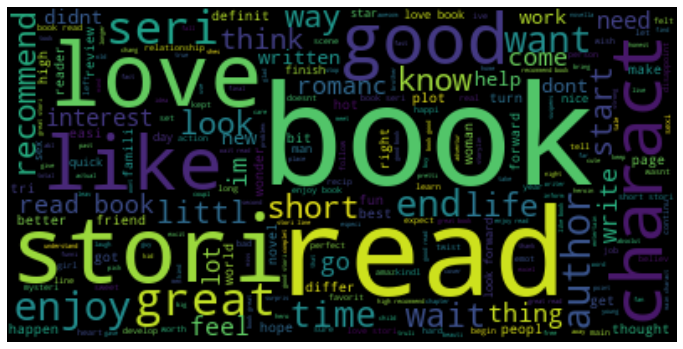

In [16]:
from wordcloud import WordCloud

cloud = WordCloud(background_color="black", 
                  max_words=X.shape[1]).generate_from_frequencies(X.T.sum(axis=1))

fig, _ = plt.subplots(1,1,figsize=(12,10))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

* Naive Forecaster 

In [17]:
def naive_forecaster(y_train):
  return np.mean(y_train)



---



* sklearn.neighbors.KNeighborsClassifier

Fitting 3 folds for each of 6 candidates, totalling 18 fits


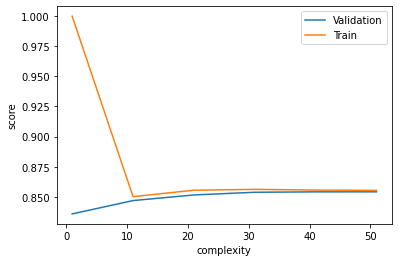

Best set of parameters: KNeighborsClassifier(n_neighbors=51)


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

neighbors = np.arange(1, 52, 10)

parameters = {'n_neighbors': neighbors}

knnCV = GridSearchCV(knn, parameters, cv=3, verbose=1,  n_jobs=3, 
                       return_train_score=True, refit=True)

knnCV.fit(X_train, y_train)

cv_results = pd.DataFrame(knnCV.cv_results_)

plt.plot(neighbors, cv_results.mean_test_score, label='Validation')
plt.plot(neighbors, cv_results.mean_train_score, label='Train')
plt.ylabel('score')
plt.xlabel('complexity')
plt.legend()
plt.show()


print('Best set of parameters:', knnCV.best_estimator_)

This graph is also displayed below for the other models. It helps to determine whether a maximum has been reached or whether a different grid needs to be considered. In general terms, the models become increasingly complex on the X-axis, eventually leading to overfitting, while the Y-axis shows the average scoring of the validation and training datasets. Note that validation and test dataset is not the same thing.



---



* sklearn.ensemble.RandomForestClassifier


As mentioned earlier, the sample is unbalanced with respect to observations labeled 1 and 0, which could affect the performance of the respective models. The sklearn RandomForestClassifier has a parameter called class_weight that makes it possible to control for unbalanced data sets.  

Fitting 3 folds for each of 9 candidates, totalling 27 fits


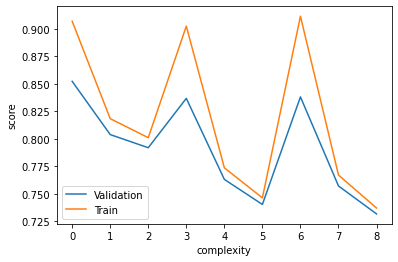

Best set of parameters: RandomForestClassifier(class_weight='balanced', max_features=0.01,
                       min_samples_split=0.01, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

n_trees = 100
split = np.arange(0.01, 0.16, 0.05)
features = np.arange(0.01, 0.16, 0.05)  
parameters = {'n_estimators': [n_trees],
              'class_weight': ['balanced'], 
              'min_samples_split': split,
              'max_features': features,
              'random_state': [42]}

rfcCV = GridSearchCV(rfc, parameters, cv=3, verbose=1, n_jobs=3, 
                       return_train_score=True, refit=True)

rfcCV.fit(X_train, y_train)

cv_results = pd.DataFrame(rfcCV.cv_results_)

plt.plot(cv_results.index, cv_results.mean_test_score, label='Validation')
plt.plot(cv_results.index, cv_results.mean_train_score, label='Train')
plt.ylabel('score')
plt.xlabel('complexity')
plt.legend()
plt.show()

print('Best set of parameters:', rfcCV.best_estimator_)



---



* sklearn.ensemble.GradientBoostingClassifier

GradientBoostingClassifier comes with no class_weight parameter to account for unbalanced samples. This is because constructing successive training sets based on misclassified samples addresses the imbalance of the samples in GradientBoostingClassifier: 

https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7

Fitting 3 folds for each of 9 candidates, totalling 27 fits


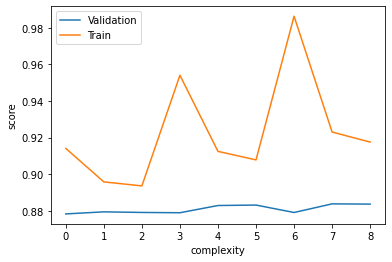

Best set of parameters: GradientBoostingClassifier(max_depth=30, min_samples_split=0.11,
                           n_estimators=150, random_state=42)


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()


stages = 150
split = np.arange(0.01, 0.22, 0.10)
depth = np.arange(10, 31, 10)
rate = 0.1
parameters = {'n_estimators': [stages], 
              'learning_rate': [rate],
              'min_samples_split': split,
              'max_depth': depth,
              'random_state': [42]}

gbcCV = GridSearchCV(gbc, parameters, cv=3, verbose=1, n_jobs=3, 
                       return_train_score=True, refit=True)

gbcCV.fit(X_train, y_train)

cv_results = pd.DataFrame(gbcCV.cv_results_)

plt.plot(cv_results.index, cv_results.mean_test_score, label='Validation')
plt.plot(cv_results.index, cv_results.mean_train_score, label='Train')
plt.ylabel('score')
plt.xlabel('complexity')
plt.legend()
plt.show()

print('Best set of parameters:', gbcCV.best_estimator_)



---



* sklearn.ensemble.AdaBoostClassifier

At the time of writing these lines, the AdaBoostClassifier does not yet have a built-in parameter to control for unbalanced data. However, there are approaches to this problem, see the paper below for more details. Implementing these approaches by hand was beyond the scope of this project, so it is expected that the AdaBoostClassifier will not be able to win the horse race: 

Li, K., Zhou, G., Zhai, J., Li, F., & Shao, M. (2019). Improved PSO_AdaBoost ensemble algorithm for imbalanced data. <i>Sensors</i>, 19(6), 1476.

In [21]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()

parameters = {'n_estimators': [100], 
              'learning_rate': [0.1],
              'random_state': [42]}

abcCV = GridSearchCV(abc, parameters, cv=3, verbose=1, n_jobs=3, return_train_score=True, refit=True)

abcCV.fit(X_train, y_train)

print('Best set of parameters:', abcCV.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best set of parameters: AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)




---



The final step is to evaluate the performance on the test data to determine the winner.

In [22]:
forecasts = pd.DataFrame(index=y_test.index)
forecast_err = pd.DataFrame(index=y_test.index)

In [23]:
from sklearn import metrics

forecasts['naive'] = naive_forecaster(y_train)

forecasts['knnCV'] = knnCV.predict_proba(X_test)[:, 1]

forecasts['rfcCV'] = rfcCV.predict_proba(X_test)[:, 1]

forecasts['gbcCV'] = gbcCV.predict_proba(X_test)[:, 1]

forecasts['abcCV'] = abcCV.predict_proba(X_test)[:, 1]


---

Determine the winner

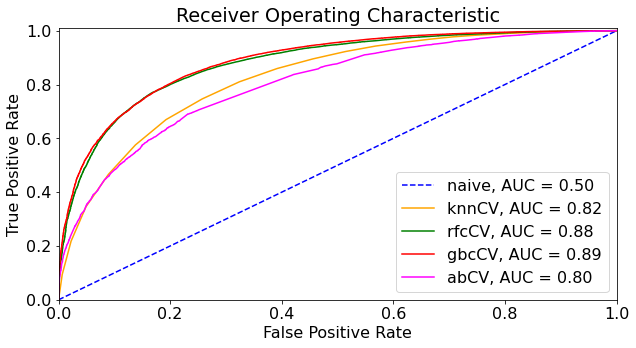

In [29]:
xax_naive, yax_naive, threshold_naive = sklearn.metrics.roc_curve(y_test, forecasts['naive'])
roc_auc_naive = sklearn.metrics.auc(xax_naive, yax_naive)

xax_knn, yax_knn, threshold_knn = sklearn.metrics.roc_curve(y_test, forecasts['knnCV'])
roc_auc_knn = sklearn.metrics.auc(xax_knn, yax_knn)

xax_rfc, yax_rfc, threshold_rfc = sklearn.metrics.roc_curve(y_test, forecasts['rfcCV'])
roc_auc_rfc = sklearn.metrics.auc(xax_rfc, yax_rfc)

xax_gbc, yax_gbc, threshold_gbc = sklearn.metrics.roc_curve(y_test, forecasts['gbcCV'])
roc_auc_gbc = sklearn.metrics.auc(xax_gbc, yax_gbc)

xax_abc, yax_abc, threshold_abc = sklearn.metrics.roc_curve(y_test, forecasts['abcCV'])
roc_auc_abc = sklearn.metrics.auc(xax_abc, yax_abc)

plt.title('Receiver Operating Characteristic')
plt.plot(xax_naive, yax_naive, 'b--', label = 'naive, AUC = %0.2f' % roc_auc_naive)
plt.plot(xax_knn, yax_knn, 'orange', label = 'knnCV, AUC = %0.2f' % roc_auc_knn)
plt.plot(xax_rfc, yax_rfc, 'green', label = 'rfcCV, AUC = %0.2f' % roc_auc_rfc)
plt.plot(xax_gbc, yax_gbc, 'red', label = 'gbcCV, AUC = %0.2f' % roc_auc_gbc)
plt.plot(xax_abc, yax_abc, 'magenta', label = 'abCV, AUC = %0.2f' % roc_auc_abc)

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 16})

#plt.rcParams["figure.figsize"] = (20,10)
#plt.rcParams.update({'font.size': 36})

plt.show()



---



The following displays the confusion matrix for the winner of the horse race. If it is particularly important for the applications to minimize either the false positives or the false negatives, this can be achieved by adjusting the threshold value. In the example below, the threshold value is set to 1/2.

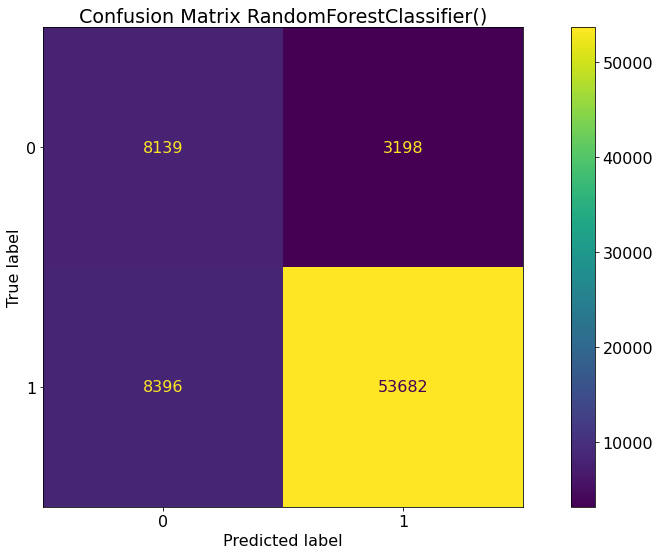

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (rfcCV.predict_proba(X_test)[:,1] >= 0.5).astype(bool) # set threshold as 0.3

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

fig, (ax1) = plt.subplots(1, figsize=(14,8))
ax1.title.set_text("Confusion Matrix RandomForestClassifier()")
disp.plot(ax = ax1)
fig.tight_layout()
plt.show()